In [1]:
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os
from astropy.io import fits
import numpy as np
from numpy import sqrt,exp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
source_name='NGC 2110'
ra=88.047400
dec=-7.456247
radius=10.
Tstart='2003-03-15T00:00:00'
Tstop='2018-03-15T00:00:00'
host='www.astro.unige.ch/cdci/astrooda/dispatch-data'
time_bin=10000
Nbibs=16 # number of time bin in the long-term lightcurve
E1_keV=30.
E2_keV=100.

In [3]:
token=input() # token for restricted access server
cookies=dict(_oauth2_proxy=token)

In [4]:
#disp=DispatcherAPI(host=host+'/dispatch-data',instrument='mock',cookies=cookies,protocol='https')
disp=DispatcherAPI(host=host)

In [5]:
import requests
url="https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/"
def queryxtime(**args):
    params=Tstart+'/'+Tstop+'?&ra='+str(ra)+'&dec='+str(dec)+'&radius='+str(radius)+'&min_good_isgri=1000'
    print(url+params)
    return requests.get(url+params,cookies=cookies).json()

In [6]:
#if token!='':
scwlist=queryxtime()
m=len(scwlist)
pointings_osa10=[]
pointings_osa11=[]
for i in range(m):
    if scwlist[i][-2:]=='10':
        if(int(scwlist[i][:4])<1626):
            pointings_osa10.append(scwlist[i]+'.001')
        else:
            pointings_osa11.append(scwlist[i]+'.001')
#else:
#    pointings=np.genfromtxt('scws_3C279_isgri_10deg.txt', dtype='str')
m_osa10=len(pointings_osa10)
m_osa11=len(pointings_osa11)

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/2003-03-15T00:00:00/2018-03-15T00:00:00?&ra=88.0474&dec=-7.456247&radius=10.0&min_good_isgri=1000


In [7]:
scw_lists_osa10=[]
scw_lists_osa11=[]
count=0
scw_string=''
for i in range(m_osa10):
    if count<50:
        scw_string=scw_string+str(pointings_osa10[i])+','
        count+=1
    else:
        scw_lists_osa10.append(scw_string[:-1])
        count=0
        scw_string=str(pointings_osa10[i])+','
scw_lists_osa10.append(scw_string[:-1])
print(len(scw_lists_osa10))
count=0
scw_string=''
for i in range(m_osa11):
    if count<50:
        scw_string=scw_string+str(pointings_osa11[i])+','
        count+=1
    else:
        scw_lists_osa11.append(scw_string[:-1])
        count=0
        scw_string=str(pointings_osa11[i])+','
scw_lists_osa11.append(scw_string[:-1])
print(len(scw_lists_osa11))






18
6


In [8]:
data=disp.get_product(instrument='isgri',
                      product='isgri_image',
                      scw_list=scw_lists_osa10[0],
                      E1_keV=E1_keV,
                      E2_keV=E2_keV,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=3.5,
                      product_type='Real')

048300050010.001,048300060010.001,048300070010.001,048300080010.001,048300160010.001,048300370010.001,048700080010.001,048700090010.001,048700100010.001,048700170010.001,048700180010.001,048700190010.001,048700580010.001,048700590010.001,048700600010.001,053000540010.001,053000550010.001,053000560010.001,053000630010.001,053000640010.001,053000660010.001,053200050010.001,053200060010.001,053200150010.001,053200360010.001,053200440010.001,053200450010.001,053200460010.001,053200470010.001,053200540010.001,053200550010.001,053200560010.001,053800040010.001,053800250010.001,053800330010.001,053800340010.001,053800350010.001,053800360010.001,053800430010.001,053800440010.001,053800450010.001,053800460010.001,053800540010.001,054300260010.001,054300340010.001,054300350010.001,054300360010.001,054300370010.001,054300430010.001,054300440010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 048300050010.001,048300060010.

In [9]:
data.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str10,float64,float64,float64,int64,int64,int64,float64
3,Ark 120,4.453483581542969,79.04783630371094,-0.15016700327396393,-32768,2,0,0.0002800000074785203
4,H 0614+091,12.6614990234375,94.28777313232422,9.13561725616455,-32768,2,0,0.0002800000074785203
14,NGC 2110,14.64085865020752,88.04682922363281,-7.458226203918457,-32768,2,0,0.0002800000074785203


In [10]:
FLAG=0
torm=[]
for ID,n in enumerate(data.dispatcher_catalog_1.table['src_names']):
    if(n[0:2]=='NEW'):
        torm.append(ID)
    if(n==source_name):
        FLAG=1
data.dispatcher_catalog_1.table.remove_rows(torm)
nrows=len(data.dispatcher_catalog_1.table['src_names'])

In [11]:
if FLAG==0:
    data.dispatcher_catalog_1.table.add_row((0,'3C 279',0,ra,dec,0,2,0,0))

data.dispatcher_catalog_1.table


meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str10,float64,float64,float64,int64,int64,int64,float64
3,Ark 120,4.453483581542969,79.04783630371094,-0.15016700327396393,-32768,2,0,0.0002800000074785203
4,H 0614+091,12.6614990234375,94.28777313232422,9.13561725616455,-32768,2,0,0.0002800000074785203
14,NGC 2110,14.64085865020752,88.04682922363281,-7.458226203918457,-32768,2,0,0.0002800000074785203


In [12]:
api_cat=data.dispatcher_catalog_1.get_api_dictionary()

In [ ]:
lc_results=[]
for i in range(len(scw_lists_osa10)):
    print(i)
    data=disp.get_product(instrument='isgri',
                        product='isgri_lc',
                        scw_list=scw_lists_osa10[i],
                        E1_keV=E1_keV,
                        E2_keV=E2_keV,
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        time_bin=time_bin,
                        selected_catalog=api_cat)
    lc_results.append(data)
    


0
048300050010.001,048300060010.001,048300070010.001,048300080010.001,048300160010.001,048300370010.001,048700080010.001,048700090010.001,048700100010.001,048700170010.001,048700180010.001,048700190010.001,048700580010.001,048700590010.001,048700600010.001,053000540010.001,053000550010.001,053000560010.001,053000630010.001,053000640010.001,053000660010.001,053200050010.001,053200060010.001,053200150010.001,053200360010.001,053200440010.001,053200450010.001,053200460010.001,053200470010.001,053200540010.001,053200550010.001,053200560010.001,053800040010.001,053800250010.001,053800330010.001,053800340010.001,053800350010.001,053800360010.001,053800430010.001,053800440010.001,053800450010.001,053800460010.001,053800540010.001,054300260010.001,054300340010.001,054300350010.001,054300360010.001,054300370010.001,054300430010.001,054300440010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 048300050010.001,04830006001

In [17]:
for i in range(len(scw_lists_osa11)):
    print(i)
    data=disp.get_product(instrument='isgri',
                        product='isgri_lc',
                        scw_list=scw_lists_osa11[i],
                        E1_keV=E1_keV,
                        E2_keV=E2_keV,
                        query_type='Real',
                        osa_version='OSA11.0',
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        time_bin=time_bin,
                        selected_catalog=api_cat)
    lc_results.append(data)



0
164400340010.001,164400550010.001,164400630010.001,164400640010.001,164400650010.001,164400660010.001,164800490010.001,164800500010.001,164800510010.001,164800520010.001,164800600010.001,166000130010.001,166400370010.001,166400450010.001,166400460010.001,166400470010.001,166400480010.001,166400490010.001,166400540010.001,166400550010.001,166400560010.001,166400570010.001,166400580010.001,166400590010.001,178100300010.001,178100390010.001,178100400010.001,178100490010.001,178100500010.001,178100590010.001,178100600010.001,179400320010.001,179400530010.001,179400620010.001,179400630010.001,179600140010.001,179600150010.001,179600160010.001,179600170010.001,179600250010.001,180100360010.001,180100560010.001,180100570010.001,180100580010.001,186800080010.001,186800090010.001,186800100010.001,186800110010.001,186800120010.001,186800130010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 164400340010.001,16440055001

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=-5818443011657541081  081 

query done succesfully!
3
187000120010.001,187000130010.001,187000140010.001,187000150010.001,187000160010.001,187000170010.001,187000180010.001,187000190010.001,187000200010.001,187000210010.001,187000220010.001,187000230010.001,187000240010.001,187000250010.001,187000260010.001,187000270010.001,187000280010.001,187000290010.001,187000300010.001,187000310010.001,187000320010.001,187000330010.001,187000340010.001,187000350010.001,187000360010.001,187000370010.001,187000380010.001,187000390010.001,187000400010.001,187000410010.001,187000420010.001,187000430010.001,187000440010.001,187000450010.001,187000460010.001,187000470010.001,187000490010.001,187000500010.001,187300060010.001,187300070010.001,187300080010.001,187300090010.001,187300100010.001,187300110010.001,187300120010.001,187300130010.001,187300140010.001,187300150010.001,187300160010.001,

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=-3442336137624335103  103 

query done succesfully!


In [18]:
t=[]
r=[]
err=[]
tot_counts=[]
backv=[]
backe=[]
i=0
for lc in lc_results:
    for ID,s in enumerate(lc._p_list):
        if s.meta_data['src_name']==source_name:
            i=i+1
            for tt in s.data_unit[1].data['TIME']:
                t.append(tt)
            for rr in s.data_unit[1].data['RATE']:
                r.append(rr)
            for ee in s.data_unit[1].data['ERROR']:
                err.append(ee)
            for tc in s.data_unit[1].data['TOT_COUNTS']:
                tot_counts.append(tc)
            for bv in s.data_unit[1].data['BACKV']:
                backv.append(bv)
            for be in s.data_unit[1].data['BACKE']:
                backe.append(be)
t=np.array(t)
r=np.array(r)
err=np.array(err)
tot_counts=np.array(tot_counts)
backv=np.array(backv)
backe=np.array(backe)

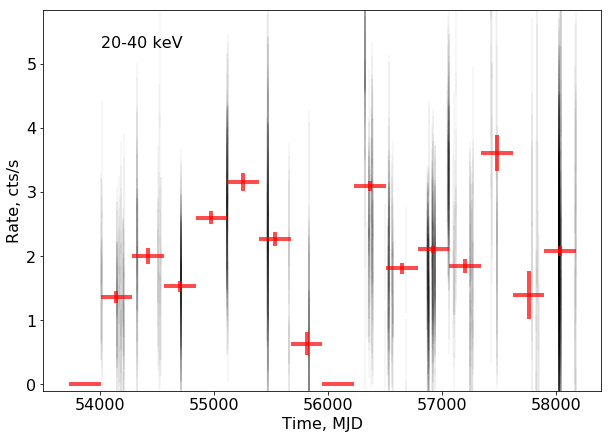

In [19]:
fig = plt.figure(figsize=(10,7))
t0=51544
Nbins=16
tmin=t0+t[0]
tmax=t0+t[-1]
time=np.linspace(tmin,tmax,Nbins)
dtime=time[1]-time[0]
time_av=time-dtime/2.
flux=np.zeros(Nbins)
error=np.zeros(Nbins)
j=0
sc=1.

k=0
while (j<len(time)):
    while ((t[k]+t0<time[j])):
        if (err[k]>0.):
            flux[j]=flux[j]+r[k]/(err[k])**2
            error[j]=error[j]+1./(err[k])**2
        k=k+1
        if (k==len(t)):
            break
    if (k==len(t)):
        break
    else:
        j=j+1
plt.errorbar(t+t0,r*exp((t+t0-52900)/40000.),yerr=err*exp((t+t0-52900)/40000.),linestyle='none',color='black',alpha=0.03,linewidth=2)

for i in range(len(flux)):
    if(error[i]>0.):
        flux[i]=flux[i]/(error[i])*exp((time_av[i]-52900)/40000.)
        error[i]=1./sqrt(error[i])*exp((time_av[i]-52900)/40000.)
plt.errorbar(time_av,flux,yerr=error,xerr=dtime/2.,linestyle='none',color='red',alpha=0.7,linewidth=4)
#plt.plot(time_av,exp((time_av-52900)/40000.)/2)
plt.tick_params(axis='both', which='major', labelsize=16)
ymax=1.5*max(flux+error)
plt.ylim(-0.1,ymax)
plt.xlabel('Time, MJD',fontsize=16)
plt.ylabel('Rate, cts/s',fontsize=16)
plt.text(tmin,0.9*ymax, '20-40 keV',fontsize=16)
name=source_name.replace(" ", "")
plt.savefig(name+'_lc.pdf',format='pdf',dpi=100)




In [65]:
lc_3C279=name+'_lc.pdf'